In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import cv2

In [2]:
def convolve(filter,mat,padding,strides):
    result = None
    filter_size = filter.shape
    mat_size = mat.shape
    if len(filter_size) == 2:
        if len(mat_size) == 3:
            channel = []
            for i in range(mat_size[-1]):
                pad_mat = np.pad(mat[:,:,i], ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
                temp = []
                for j in range(0,mat_size[0],strides[1]):
                    temp.append([])
                    for k in range(0,mat_size[1],strides[0]):
                        val = (filter*pad_mat[j:j+filter_size[0],k:k+filter_size[1]]).sum()
                        temp[-1].append(val)
                channel.append(np.array(temp))

            channel = tuple(channel)
            result = np.dstack(channel)
        elif len(mat_size) == 2:
            channel = []
            pad_mat = np.pad(mat, ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
            for j in range(0, mat_size[0], strides[1]):
                channel.append([])
                for k in range(0, mat_size[1], strides[0]):
                    val = (filter * pad_mat[j:j + filter_size[0],k:k + filter_size[1]]).sum()
                    channel[-1].append(val)


            result = np.array(channel)

    return result

In [3]:
def linear_convolve(filter,mat,padding=None,strides=[1,1]):
    result = None
    filter_size = filter.shape
    if len(filter_size) == 2 and 1 in filter_size:
        if padding == None or len(padding) < 2:
            if filter_size[1] == 1:
                padding = [filter_size[0]//2,filter_size[0]//2]
            elif filter_size[0] == 1:
                padding = [filter_size[1]//2,filter_size[1]//2]
        if filter_size[0] == 1:
            result = convolve(filter,mat,[0,0,padding[0],padding[1]],strides)
        elif filter_size[1] == 1:
            result = convolve(filter, mat, [padding[0],padding[1],0,0], strides)

    return result

In [4]:
def _2_dim_divided_convolve(filter,mat):
    result = None
    if 1 in filter.shape:
        result = linear_convolve(filter,mat)
        result = linear_convolve(filter.T,result)

    return result

In [5]:
def hysteresis(m2,threshold):
    e = 0.01
    s = []
    coordinate = []
    for i in range(m2.shape[0]):
        coordinate.append([])
        for j in range(m2.shape[1]):
            coordinate[-1].append([i,j])
            if abs(m2[i,j] - 255) < e:
                s.append([i,j])
    coordinate = np.array(coordinate)

    while not len(s) == 0:
        index = s.pop()
        hysteresis = m2[max(0, index[0] - 1):min(index[0] + 2, m2.shape[1]), max(0, index[1] - 1):min(index[1] + 2, m2.shape[0])]
        hysteresis_i = coordinate[max(0, index[0] - 1):min(index[0] + 2, coordinate.shape[1]), max(0, index[1] - 1):min(index[1] + 2, coordinate.shape[0])]
        hysteresis = (hysteresis > threshold[0])&(hysteresis < threshold[1])
        hysteresis_i = hysteresis_i[hysteresis]
        for i in range(hysteresis_i.shape[0]):
            s.append(list(hysteresis_i[i]))
            m2[hysteresis_i[i][0],hysteresis_i[i][1]] = 255

    return m2

In [6]:
def non_maximum_supression(g_l,g_t,threshold = None):
    if threshold == None:
        lower_boundary = g_l.mean()*0.5
        threshold = [lower_boundary,lower_boundary*3]
    result = np.zeros(g_l.shape)

    for i in range(g_l.shape[0]):
        for j in range(g_l.shape[1]):
            is_local_extreme = True
            eight_neighborhood = g_l[max(0,i-1):min(i+2,g_l.shape[0]),max(0,j-1):min(j+2,g_l.shape[1])]
            if eight_neighborhood.shape == (3,3):
                if g_t[i,j] <= -1:
                    x = 1/g_t[i,j]
                    first = eight_neighborhood[0,1] + (eight_neighborhood[0,1] - eight_neighborhood[0,0])*x
                    x = -x
                    second = eight_neighborhood[2,1] + (eight_neighborhood[2,2] - eight_neighborhood[2,1])*x
                    if not (g_l[i,j] > first and g_l[i,j] > second):
                        is_local_extreme = False
                elif g_t[i,j] >= 1:
                    x = 1 / g_t[i, j]
                    first = eight_neighborhood[0, 1] + (eight_neighborhood[0, 2] - eight_neighborhood[0, 1]) * x
                    x = -x
                    second = eight_neighborhood[2, 1] + (eight_neighborhood[2, 1] - eight_neighborhood[2, 0]) * x
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
                elif g_t[i,j] >= 0 and g_t[i,j] < 1:
                    y = g_t[i, j]
                    first = eight_neighborhood[1, 2] + (eight_neighborhood[0, 2] - eight_neighborhood[1, 2]) * y
                    y = -y
                    second = eight_neighborhood[1, 0] + (eight_neighborhood[1, 0] - eight_neighborhood[2, 0]) * y
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
                elif g_t[i,j] < 0 and g_t[i,j] > -1:
                    y = g_t[i, j]
                    first = eight_neighborhood[1, 2] + (eight_neighborhood[1, 2] - eight_neighborhood[2, 2]) * y
                    y = -y
                    second = eight_neighborhood[1, 0] + (eight_neighborhood[0, 0] - eight_neighborhood[1, 0]) * y
                    if not (g_l[i, j] > first and g_l[i, j] > second):
                        is_local_extreme = False
            if is_local_extreme:
                result[i,j] = g_l[i,j]

    result[result>=threshold[1]] = 255
    result[result<=threshold[0]] = 0

    result = hysteresis(result,threshold)
    result[result!=255] = 0
    return result

In [7]:
def standard_normal_distribution(x,sigma):
    E = -0.5/(sigma*sigma)
    return 1/(math.sqrt(2*math.pi)*sigma)*math.exp(x*x*E)

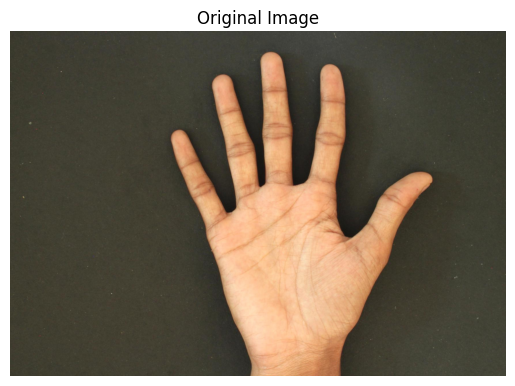

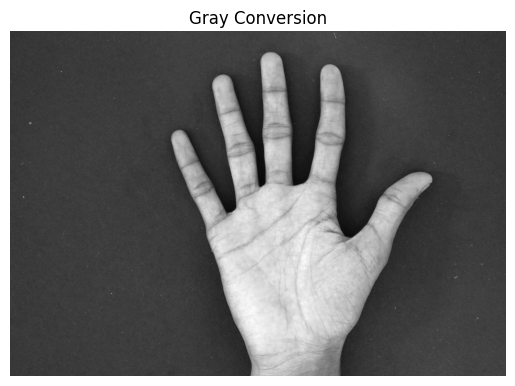

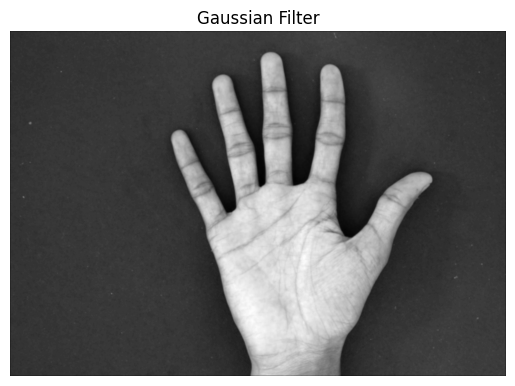

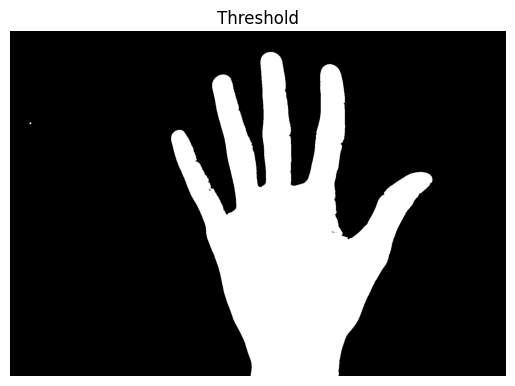

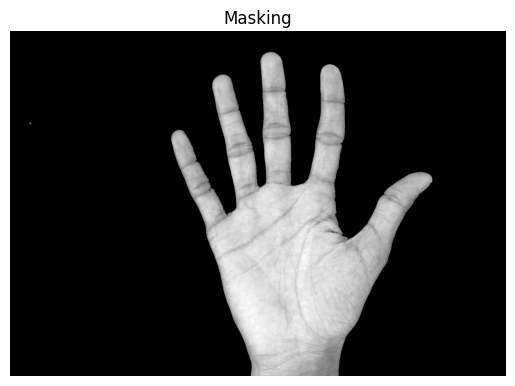

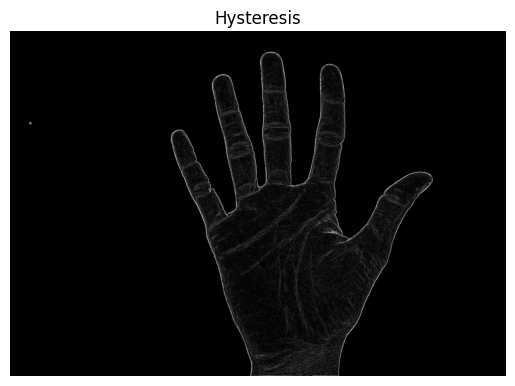

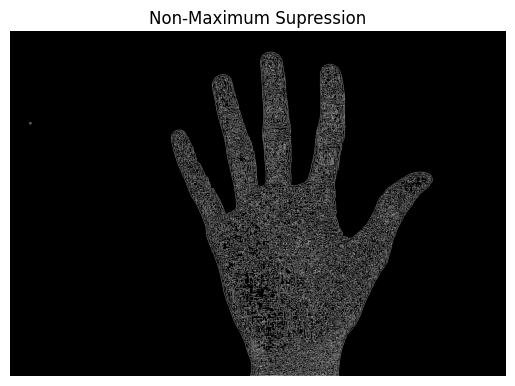

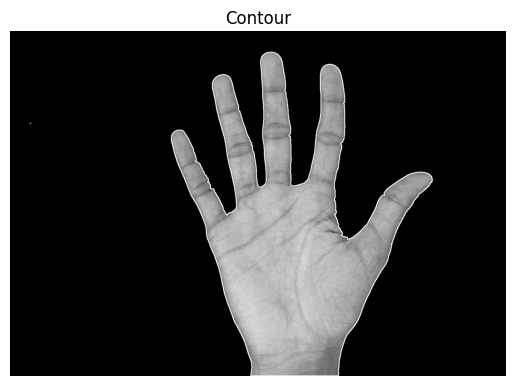

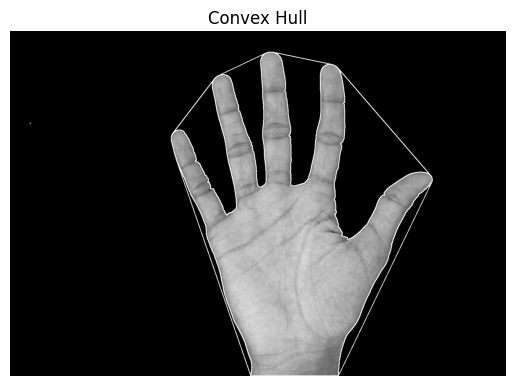

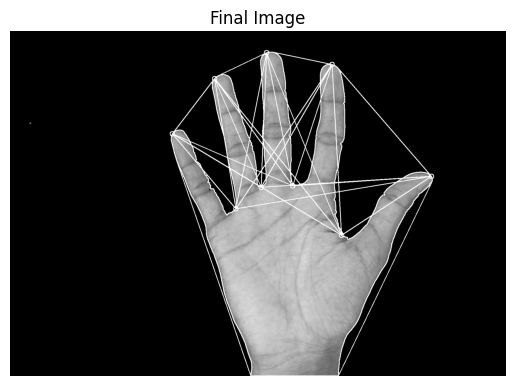

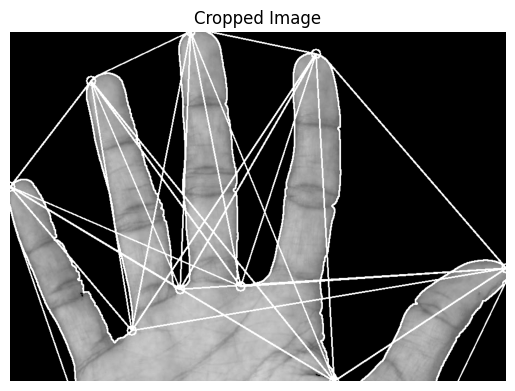

manhattan_distance: [[495, 600, 482, 942], [540, 645, 527, 987], [487, 554, 650, 896], [674, 559, 837, 627], [631, 516, 794, 518]]
euclidean_distance: [[360.6618915272308, 456.42304937415247, 341.9970760108922, 686.680420574229], [411.25174771665104, 461.64163590386863, 459.0043572777932, 701.7043536989064], [468.3855249684815, 471.85802949616107, 553.4419572096066, 686.5464296025433], [493.2930163705949, 443.68119184838116, 603.5138772223884, 594.9159604515582], [594.2162905878633, 484.1260166526893, 690.3115238788934, 374.1577207542295]]


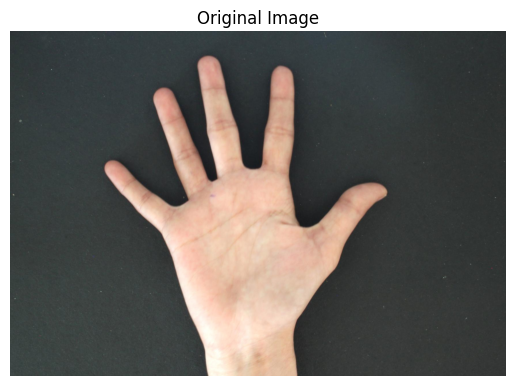

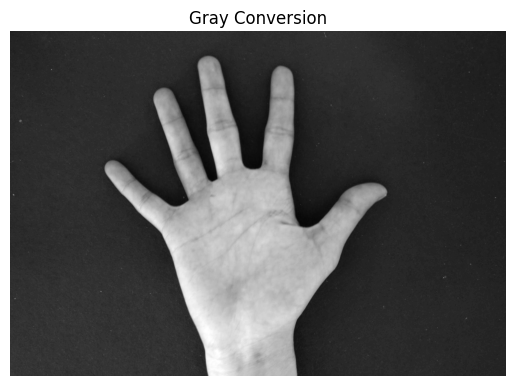

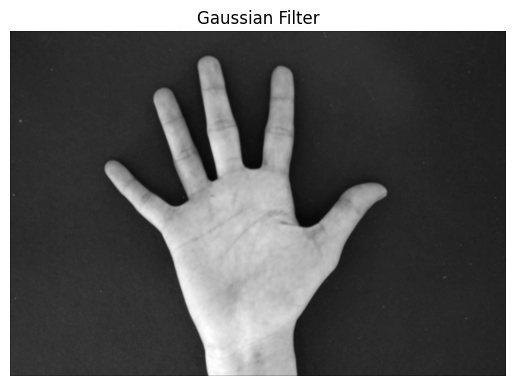

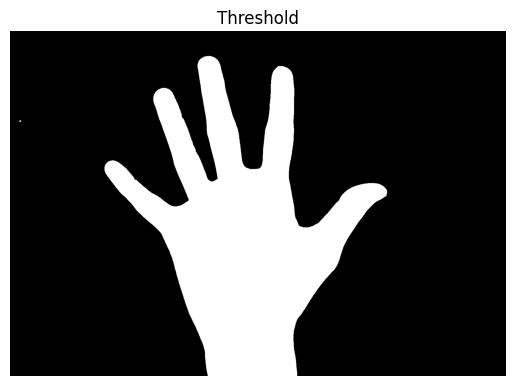

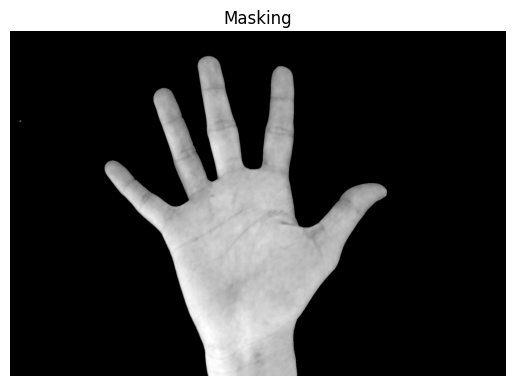

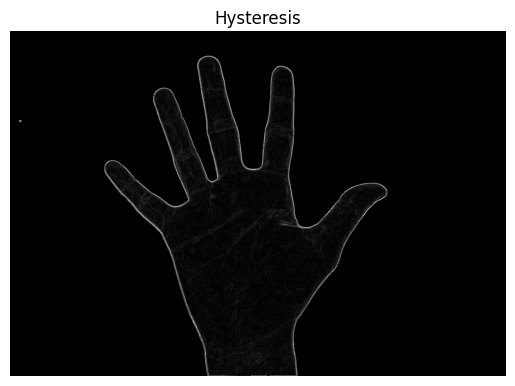

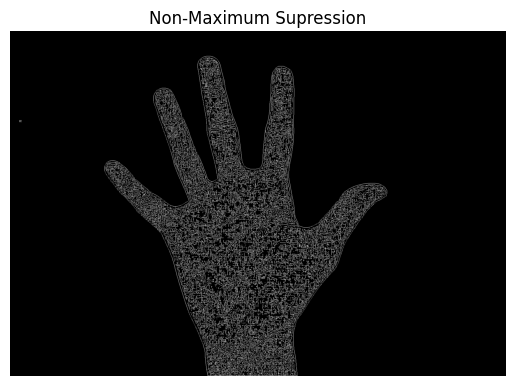

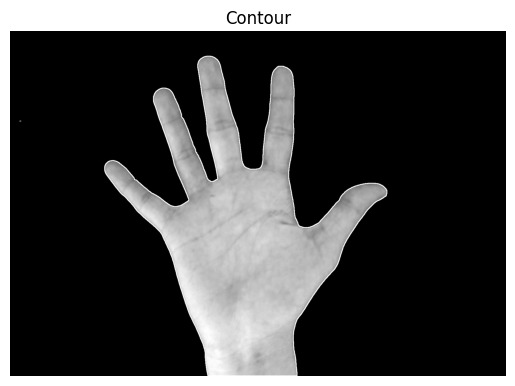

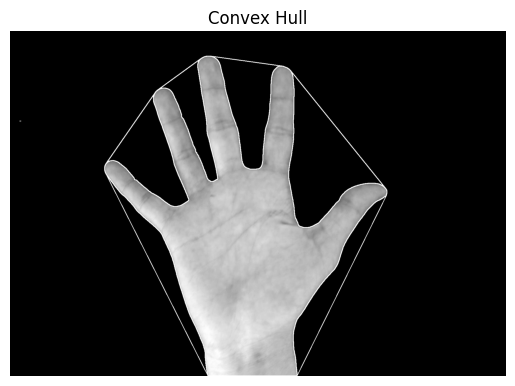

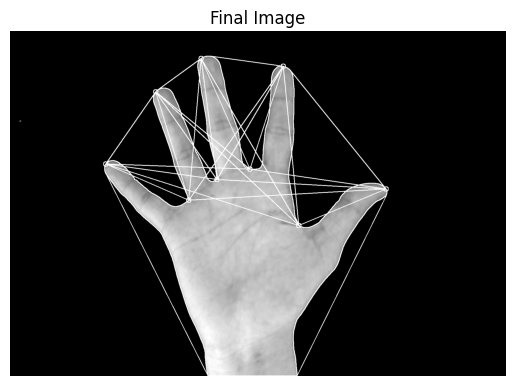

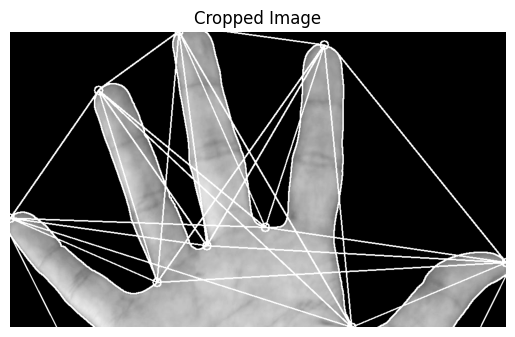

manhattan_distance: [[441, 520, 415, 886], [518, 597, 492, 963], [476, 555, 536, 921], [625, 474, 795, 608], [622, 543, 726, 431]]
euclidean_distance: [[390.7492802296634, 502.3226055036743, 315.27289766169247, 705.2517281084819], [372.01344061740565, 424.19924563817887, 394.14971774694953, 681.3435256902351], [424.5774369888254, 420.86221023037933, 494.87170054469675, 673.1723404894174], [456.72420562085387, 376.3243282064023, 570.4357983156386, 556.6255473835171], [589.9237238830118, 478.99582461645736, 688.1060964705952, 329.46168214224855]]


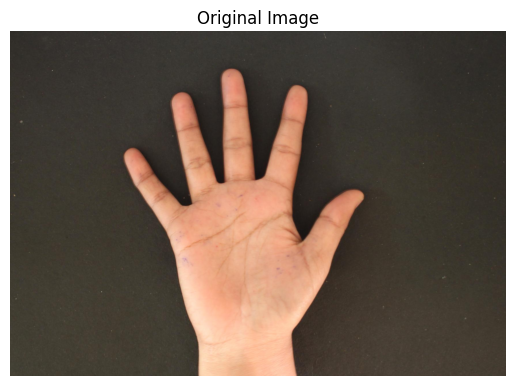

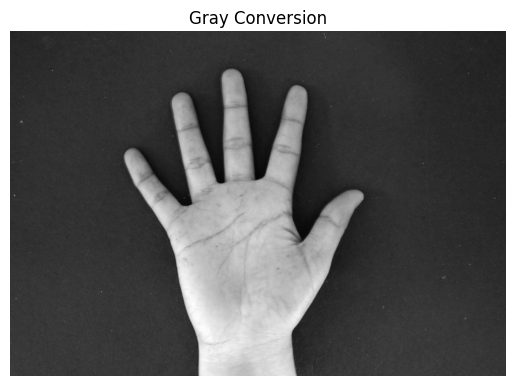

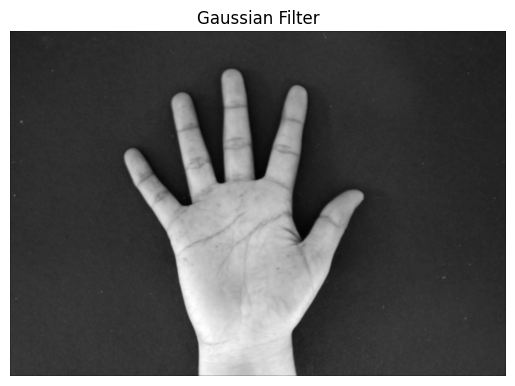

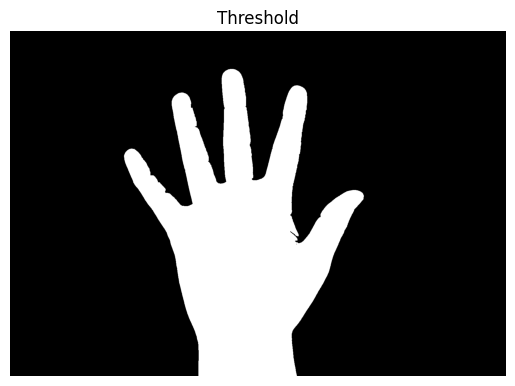

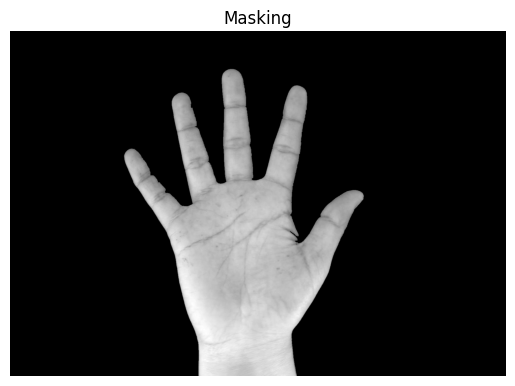

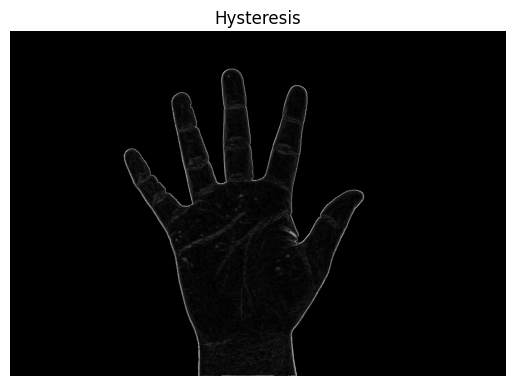

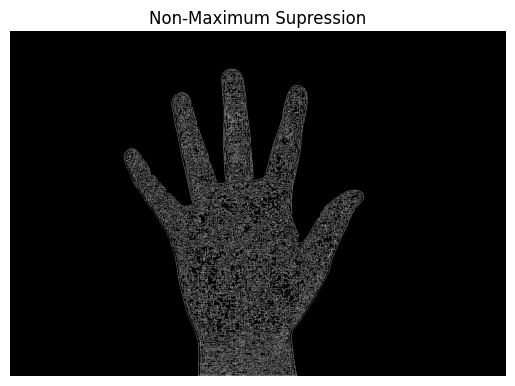

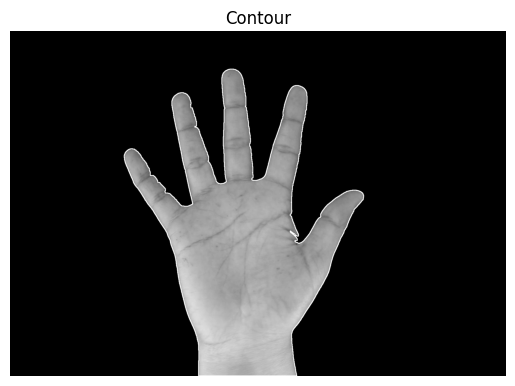

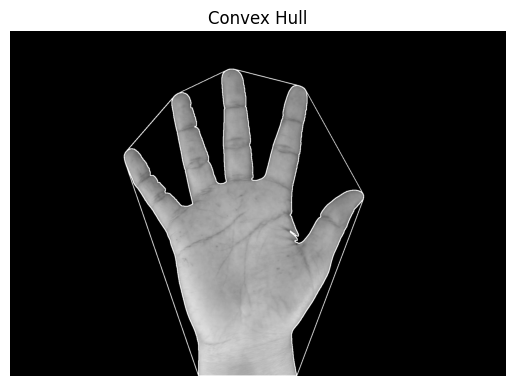

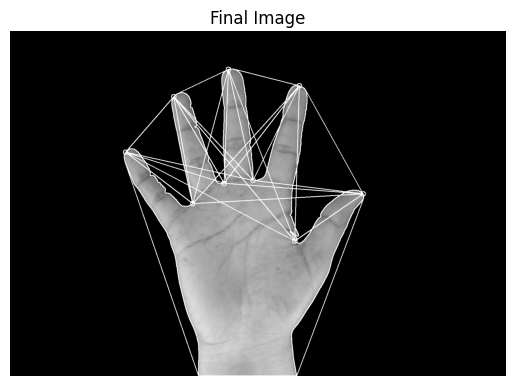

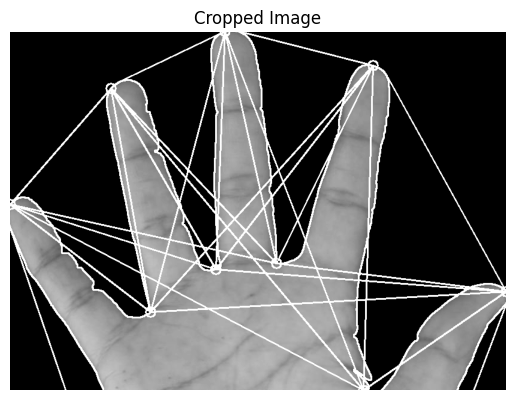

manhattan_distance: [[451, 542, 413, 898], [476, 567, 438, 923], [411, 472, 591, 828], [601, 490, 781, 556], [521, 430, 627, 402]]
euclidean_distance: [[359.60116796250816, 454.686705325766, 294.61330587738223, 665.1330693928847], [348.1752432324849, 401.06981935817606, 377.809475794348, 655.1679174074384], [396.2839890785395, 395.4642841016114, 483.18216026670524, 640.1327987222651], [428.4448622635123, 366.2813126546316, 552.9385137607978, 540.2369850352713], [485.41219597368996, 385.873036114212, 593.9739051507229, 289.03287010303865]]


In [8]:
sobel_kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

pic_path = './img/'
pics = os.listdir(pic_path)

for i in pics:
    if i[-4:] == '.png'or i[-4:] == '.jpg' or i[-5:] == '.jpeg':

        # Read File
        filename = pic_path + i
        oriImg = cv2.imread(filename, cv2.IMREAD_COLOR)

        # Show Original Image
        plt.imshow(oriImg.astype(np.uint8)[:,:,::-1])
        plt.axis('off')
        plt.title("Original Image")
        plt.show()
        
        if i[-4:] == '.png':
            oriImg = oriImg*255

        # Gray Conversion
        img = np.dot(oriImg[...,:3], [0.21, 0.72, 0.07])
        img = img.astype(np.uint8)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("Gray Conversion")
        plt.show()

        sigma = 1.5
        dim = int(np.round(6*sigma+1))
        if dim % 2 == 0:
            dim += 1
        linear_gaussian_filter = [np.abs(t - (dim//2)) for t in range(dim)]
        linear_gaussian_filter = np.array([[standard_normal_distribution(t,sigma) for t in linear_gaussian_filter]])
        linear_gaussian_filter = linear_gaussian_filter/linear_gaussian_filter.sum()

        # Gaussian Filter
        gaussian_img = _2_dim_divided_convolve(linear_gaussian_filter,img)
        plt.imshow(gaussian_img.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Gaussian Filter")
        plt.show()

        # Thresholding
        ret, thresh = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
        kernel = np.ones((5,5),np.uint8)
        thresh = cv2.erode(thresh, kernel, iterations=1)
        thresh = cv2.dilate(thresh, kernel, iterations=1)
        plt.imshow(thresh.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Threshold")
        plt.show()

        # Masking
        masked = cv2.bitwise_and(img, img, mask=thresh)
        plt.imshow(masked.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Masking")
        plt.show()

        # Sobel Filter
        sobel_x = convolve(sobel_kernel_x,masked,[1,1,1,1],[1,1])
        sobel_y = convolve(sobel_kernel_y,masked,[1,1,1,1],[1,1])
        gradiant_length = (sobel_x**2+sobel_y**2)**(1.0/2)
        sobel_x = sobel_x.astype(np.float64)
        sobel_y = sobel_y.astype(np.float64)
        sobel_x[sobel_x==0]=0.00000001
        gradiant_tangent = sobel_y/sobel_x

        # Hysteresis
        plt.imshow(gradiant_length.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Hysteresis")
        plt.show()

        # Non-Maximum Supression
        final_img = non_maximum_supression(gradiant_length,gradiant_tangent)
        plt.imshow(final_img.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Non-Maximum Supression")
        plt.show()

        # Contour
        contours, hierarchy = cv2.findContours(masked, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = max(contours, key=lambda x: cv2.contourArea(x))
        cv2.drawContours(masked, [contours], -1, (255,255,255), 2)
        plt.imshow(masked.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Contour")
        plt.show()

        # Convex Hull
        hull = cv2.convexHull(contours)
        cv2.drawContours(masked, [hull], -1, (255, 255, 255), 2)
        plt.imshow(masked.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Convex Hull")
        plt.show()

        # Convexity Defects
        hull = cv2.convexHull(contours, returnPoints=False)
        defects = cv2.convexityDefects(contours, hull)

        if defects is not None:
            keypoint = []

        for i in range(defects.shape[0]):
            s, e, f, d = defects[i][0]
            start = tuple(contours[s][0])
            end = tuple(contours[e][0])
            far = tuple(contours[f][0])
            a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
            b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
            c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
            angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
            if angle <= np.pi / 2:
                for each in [start, far, end]:
                    keypoint.append([start, far, end])

            keypoint.sort(key=lambda x: x[0][1])
            unique_keypoint = []

            for i in range(len(keypoint)):
                if i == 0:
                    unique_keypoint.append(keypoint[i])
                else:
                    if keypoint[i][0][1] - unique_keypoint[-1][0][1] > 10:
                        unique_keypoint.append(keypoint[i])

        # Draw Keypoint & Line
        euclidean = []
        manhattan = []
        for i in range(len(unique_keypoint)):
            for j in range(len(unique_keypoint)):
                cv2.putText(img, str(i), unique_keypoint[i][0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                if i == 2:
                    cv2.circle(masked, unique_keypoint[i][1], 8, [255, 255, 255], 2)

                    cv2.circle(masked, unique_keypoint[i][2], 8, [255, 255, 255], 2)
                    cv2.line(masked, unique_keypoint[i][2], unique_keypoint[j][1], (255, 255, 255), 2)
                    euclidean.append(np.sqrt((unique_keypoint[i][2][0] - unique_keypoint[j][1][0]) ** 2 + (unique_keypoint[i][2][1] - unique_keypoint[j][1][1]) ** 2))
                    manhattan.append(np.abs(unique_keypoint[i][2][0] - unique_keypoint[j][1][0]) + np.abs(unique_keypoint[i][2][1] - unique_keypoint[j][1][1]))

                    cv2.circle(masked, unique_keypoint[i][0], 8, [255, 255, 255], 2)
                    cv2.line(masked, unique_keypoint[i][0], unique_keypoint[j][1], (255, 255, 255), 2)
                    euclidean.append(np.sqrt((unique_keypoint[i][0][0] - unique_keypoint[j][1][0]) ** 2 + (unique_keypoint[i][0][1] - unique_keypoint[j][1][1]) ** 2))
                    manhattan.append(np.abs(unique_keypoint[i][0][0] - unique_keypoint[j][1][0]) + np.abs(unique_keypoint[i][0][1] - unique_keypoint[j][1][1]))

                else:
                    cv2.circle(masked, unique_keypoint[i][0], 8, [255, 255, 255], 2)
                    cv2.circle(masked, unique_keypoint[i][1], 8, [255, 255, 255], 2)
                    cv2.line(masked, unique_keypoint[i][0], unique_keypoint[j][1], (255, 255, 255), 2)
                    euclidean.append(np.sqrt((unique_keypoint[i][0][0] - unique_keypoint[j][1][0]) ** 2 + (unique_keypoint[i][0][1] - unique_keypoint[j][1][1]) ** 2))
                    manhattan.append(np.abs(unique_keypoint[i][0][0] - unique_keypoint[j][1][0]) + np.abs(unique_keypoint[i][0][1] - unique_keypoint[j][1][1]))

        # Final Image
        plt.imshow(masked.astype(np.uint8), cmap='gray')
        plt.axis('off')
        plt.title("Final Image")
        plt.show()

        # Crop Image
        min_x = min(unique_keypoint, key=lambda x: x[0][0])[-1][0]
        max_x = max(unique_keypoint, key=lambda x: x[0][0])[0][0]
        min_y = min(unique_keypoint, key=lambda x: x[0][1])[0][1]
        max_y = max(unique_keypoint, key=lambda x: x[0][1])[1][1]
        crop_img = masked[min_y:max_y, min_x:max_x]
        plt.imshow(crop_img.astype(np.uint8), cmap='gray')
        plt.axis("off")
        plt.title("Cropped Image")
        plt.show()

        # Store Manhattan & Euclidean Distance
        pinky_manhattan = manhattan[8:15:2]
        ring_manhattan = manhattan[9:16:2]
        middle_manhattan = manhattan[0:4]
        leading_manhattan = manhattan[4:8]
        thumb_manhattan = manhattan[16:21]
        manhattan_distance = [pinky_manhattan, ring_manhattan, middle_manhattan, leading_manhattan, thumb_manhattan]
        print(f"manhattan_distance: {manhattan_distance}")

        pinky_euclidean = euclidean[8:15:2]
        ring_euclidean = euclidean[9:16:2]
        middle_euclidean = euclidean[0:4]
        leading_euclidean = euclidean[4:8]
        thumb_euclidean = euclidean[16:21]
        euclidean_distance = [pinky_euclidean, ring_euclidean, middle_euclidean, leading_euclidean, thumb_euclidean]
        print(f"euclidean_distance: {euclidean_distance}")
